# 非線形システムの位相図の描画
以下の tunnel-diode circuit model を例にする．
$$
\dot{x}_1 = 0.5 (-h(x_1) + x_2), \\
\dot{x}_2 = 0.2(-x_1 - 1.5 x_2 + 1.2),
$$
ただし，
$$
h(x_1) = 17.76 x_1 - 103.79 x_1^2 + 229.62 x_1^3 - 226.31 x_1^4 + 83.72 x_1^5
$$
とする．

In [1]:
##### Packages #####
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve 
import os
####################

In [2]:
##### settings of plt #####
plt.rcParams["font.family"] = "serif"       # fonts
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 18              
plt.rcParams["mathtext.cal"] = "serif"      
plt.rcParams["mathtext.rm"] = "serif"       
plt.rcParams["mathtext.it"] = "serif:italic"
plt.rcParams["mathtext.bf"] = "serif:bold"  
plt.rcParams["mathtext.fontset"] = "cm"  
###########################

In [3]:
class System():
    """
    システムの定義
    """
    def h(self, x_1):
        """
        関数 h の定義．

        Args:
            x_1 (float): x_1 の値
        
        Returns:
            float: h(x_1) の値
        """
        return 17.76*x_1 - 103.79*x_1**2 + 229.62*x_1**3 - 226.31*x_1**4 + 83.72*x_1**5 

    def dynamics(self, t, z):
        """
        x のダイナミクス． 

        Args:
            t (float): 時刻，scipy.integrate.solve_ivp で数値的に解くために必要．
            z (numpy.ndarray): 状態ベクトル
        
        Returns:
            numpy.ndarray: ダイナミクス
        """
        x = z 
        dyn = np.empty_like(x)
        dyn[0] = 0.5*((-1)*self.h(x[0]) + x[1])
        dyn[1] = 0.2*(-x[0] - 1.5*x[1] + 1.2)
        return dyn 
    
    def dynamics_without_t(self, z):
        """
        x のダイナミクス (tなし)

        Args:
            z (numpy.ndarray): 状態ベクトル
        
        Returns:
            numpy.ndarray: ダイナミクス
        """
        return self.dynamics(0, z)
    
    def equilibrium_point(self, yinit):
        """
        ダイナミクスの平衡点

        Args:
            yinit (numpy.ndarray): 初期解
        
        Returns:
            numpy.ndarray: 平衡点
        """
        return fsolve(func=self.dynamics_without_t, x0=yinit)
    
    def dynamics_reversed(self, t, z):
        """
        逆時間のダイナミクス．

        Args:
            t (float): 時刻，scipy.integrate.solve_ivp で数値的に解くために必要．
            z (numpy.ndarray): 状態ベクトル
        
        Returns:
            numpy.ndarray: 逆時間のダイナミクス
        """
        return (-1)*self.dynamics(t, z)
    
    def solve_dynamics(self, yinit, T, N):
        """
        ダイナミクスの解軌道を数値的に求める (参考: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)

        Args:
            yinit (numpy.ndarray): 初期状態
            T (float): 終端時刻
            N (int): 時間の区切りの数
        
        Returns:
            numpy.ndarray: 解軌道
        """
        sol = solve_ivp(fun=self.dynamics, t_span=[0, T], y0=yinit, method='RK45', dense_output=True, rtol=1e-8, atol=1e-8)
        t = np.linspace(0, T, N)
        z = sol.sol(t)
        return z 
    
    def solve_dynamics_reversed(self, yinit, T, N):
        """
        逆時刻のダイナミクスの解軌道を数値的に求める

        Args:
            yinit (numpy.ndarray): 初期状態
            T (float): 終端時刻
            N (int): 時間の区切りの数
        
        Returns:
            numpy.ndarray: 解軌道
        """
        sol = solve_ivp(fun=self.dynamics_reversed, t_span=[0, T], y0=yinit, method='RK45', dense_output=True, rtol=1e-8, atol=1e-8)
        t = np.linspace(0, T, N)
        z = sol.sol(t)
        return z 

In [4]:
class Phase_portrait(System):
    """
    位相図の描画等を行う
    """
    def phase_portrait(self, stable_list, unstable_list, equiv_list):
        """
        位相図の描画を行う

        Args:
            stable_list (list): 安定多様体のリスト
            unstable_list (list): 不安定多様体のリスト
            equiv_list (list): 平衡点のリスト
        """
        ##### vector field #####
        x_range = np.linspace(-0.4, 1.6, 21)
        y_range = np.linspace(-0.4, 1.6, 21)
        X, Y = np.meshgrid(x_range, y_range)    # 格子点を作る, size: (21, 21)
        dX = np.empty_like(X); dY = np.empty_like(Y)
        for i in range(len(X)):
            for j in range(len(X[i])):
                vecx = np.array([X[i][j], Y[i][j]]) # (i, j)におけるベクトルx
                dX[i][j] = self.dynamics(0, vecx)[0]    # ダイナミクスのx成分
                dY[i][j] = self.dynamics(0, vecx)[1]    # ダイナミクスのy成分
        ########################

        ##### plot #####

        ### difine figure ###
        fig = plt.figure(figsize=(8,6))
        fig.subplots_adjust(bottom=0.15, left=0.15)
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel(r'$x_1$'); ax.set_ylabel(r'$x_2$')
        ax.set_xlim([-0.4, 1.6]); ax.set_ylim([-0.4, 1.6])
        #####################

        ### calculate the norm of vector ###
        nrm = np.sqrt(pow(dX, 2) + pow(dY, 2))
        maxnrm = []; minnrm = []
        for i in range(len(nrm)):
            # 各 i に対して nrm[i] の size は 21
            maxnrm.append(max(nrm[i]))  # nrm[i] の最大値
            minnrm.append(min(nrm[i]))  # nrm[i] の最小値
        ####################################

        ### plot vector and add colorbar ###
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("top", size="5%", pad=0.3)
        # ベクトルの正規化．ノルムが0のところは0にする．
        dX_nrm = np.divide(dX, nrm, out=np.zeros_like(dX), where=nrm!=0)
        dY_nrm = np.divide(dY, nrm, out=np.zeros_like(dY), where=nrm!=0)
        # ベクトル場の描画
        im = ax.quiver(X, Y, dX_nrm, dY_nrm, nrm, cmap='winter_r')
        # colorbar の描画
        cbar = fig.colorbar(im, cax=cax, ticks=[min(minnrm), max(maxnrm)], orientation='horizontal')
        cax.xaxis.set_ticks_position('top')
        cbar.ax.set_xlim(min(minnrm),max(maxnrm))
        cbar.ax.set_xticklabels(['Low', 'High'])  # horizontal colorbar
        ####################################

        ### plot stable manifold ###
        if stable_list != []:
            for sol in stable_list:
                ax.plot(sol[0], sol[1], c='m')
        ############################

        ### plot unstable manifold ###
        if unstable_list != []:
            for sol in unstable_list:
                ax.plot(sol[0], sol[1], c='r')
        ##############################

        ### plot equilibrium points ###
        if equiv_list != []:
            for equiv in equiv_list:
                ax.scatter(equiv[0], equiv[1], c='k', marker='o', s=20)
        ###############################

        ### save and show figure ###
        plt.show()
        ############################
        ################
        

In [5]:
def main():
    ##### Parameters #####
    T = 100 
    N = 10000
    ######################
    y1 = np.array([0, 0])
    y2 = np.array([0.2, 0.6])
    y3 = np.array([0.8, 0.2])
    dplus = np.array([0.001, 0.001])
    dminus = np.array([0.001, -0.001])

    ph = Phase_portrait()
    ##### equilibrium points #####
    q_1 = ph.equilibrium_point(y1)
    q_2 = ph.equilibrium_point(y2)
    q_3 = ph.equilibrium_point(y3)
    ##############################
    equiv_list = [q_1, q_2, q_3]
    stable_list = []; unstable_list = []
    ##### stable manifold #####
    sol_q2_1 = ph.solve_dynamics_reversed(q_2+dminus, T, N)
    stable_list.append(sol_q2_1)
    sol_q2_2 = ph.solve_dynamics_reversed(q_2+dplus, T, N)
    stable_list.append(sol_q2_2)
    ###########################

    ##### unstable manifold #####
    sol_q2_3 = ph.solve_dynamics(q_2+dminus, T, N)
    unstable_list.append(sol_q2_3)
    sol_q2_4 = ph.solve_dynamics(q_2-dminus, T, N)
    unstable_list.append(sol_q2_4)
    #############################

    ph.phase_portrait(stable_list, unstable_list, equiv_list)
    

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


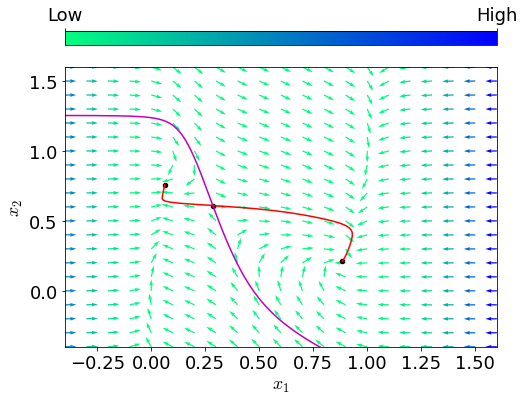

In [6]:
if __name__ == "__main__":
    main()